In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scikit_posthocs as sp
import os
from kneed import KneeLocator
from decimal import Decimal
from collections import Counter
from scipy import stats
from Bio import SeqIO

In [4]:
geneID_file = '../data/all_human_genes_ID.txt'
enstEnsg_file = '../data/human_ENST_ENSG_symbol.tsv'
dctEnstEnsg_file = '../data/dct_enstToensg.pkl'
data_file = '../data/binary_lncrna_interpretation.tsv'
dataPval_file = '../data/binary_lncrna_interpret_pvalues_abs.txt'
cosmic_file = '../data/COSMIC_censusGenes.tsv'
dctTumor_file = '../data/dct_tumor.pkl'
conservationPos_file = '../data/conservation_lncRNA_highPos_subset.tsv'
conservationNeg_file = '../data/conservation_lncRNA_highNeg_subset.tsv'
conservationNeutral_file = '../data/conservation_lncRNA_neutral_subset.tsv'
highPos_file = '../data/genes_lncRNA_high_pos.txt'
highNeg_file = '../data/genes_lncRNA_high_neg.txt'
neutral_file = '../data/genes_lncRNA_neutral.txt'
highPos_fasta = '../data/genes_lncRNA_high_pos.fa'
highNeg_fasta = '../data/genes_lncRNA_high_neg.fa'
neutral_fasta = '../data/genes_lncRNA_neutral.fa'
pyknonPos_file = '../data/dct_pyknons_lncRNA_highPos.pkl'
pyknonNeg_file = '../data/dct_pyknons_lncRNA_highNeg.pkl'
pyknonNeutral_file = '../data/dct_pyknons_lncRNA_neutral.pkl'

In [5]:
df_ref = pd.read_csv(geneID_file, sep='\t')

dct_ref = dict(zip(df_ref['Gene stable ID'], df_ref['Gene name']))

df_pc = pd.read_csv(data_file, sep='\t', index_col=0)
## change gene ID from ensembleID to gene symbol
df_pc.columns = df_pc.columns.map(dct_ref)


In [ ]:
## make dictionaries to group samples by tumor type, tissue type or dataset when necessary
with open(dctTumor_file, 'rb') as dct_tumor:
    dct_tumor = pickle.load(dct_tumor)

In [5]:
def write_pval(pval, x, y, threshold):
    if pval < threshold:
        plt.text(x, y, '%.2e' % Decimal(pval), fontsize=font_size, ha='center', va='bottom')
    else:
        plt.text(x, y, '%.3f' % pval, fontsize=font_size, ha='center', va='bottom')

## selection of high-attribution features

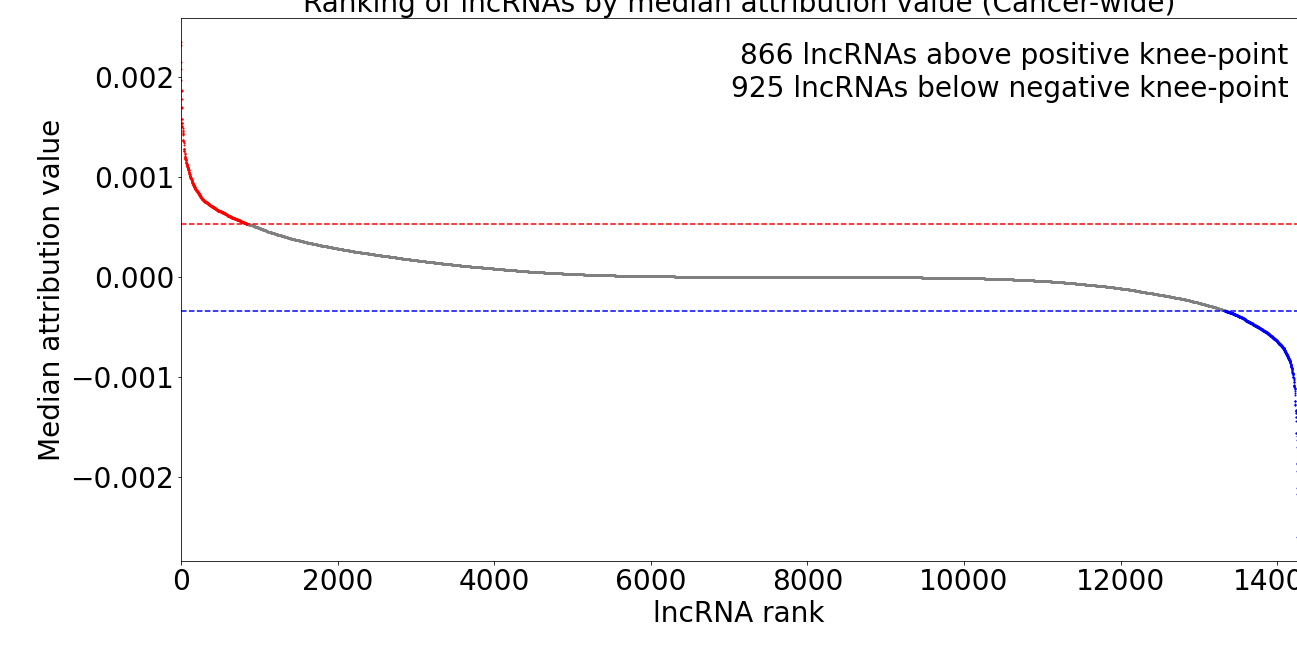

In [6]:
## plot distribution of attribution values showing median to find kneepoints

## function to smoothen curve made up of attribution values
def smooth(y, box_pts):
        y_smooth = np.convolve(y, np.ones((box_pts,)) / float(box_pts), mode='valid')
        return y_smooth
    
    
## breaking down plot between positive and negative attributions and finding the two knee points

attr_median = pd.read_csv(dataPval_file,
                        sep='\t', index_col=0)

attr_median.index = attr_median.index.map(dct_ref)

attr_median['pval'] = -np.log10(attr_median['Corrected P-values (FDR <= 1%)'])

## sort df_attr from highest to lowest attribution value
attr_median = attr_median.sort_values(by='Median-Attributions', ascending=False)

attr_median_pos = attr_median[attr_median['Median-Attributions'] >= 0]
attr_median_neg = attr_median[attr_median['Median-Attributions'] < 0]


x = [x for x in range(len(attr_median.index))]
xpos = [x for x in range(len(attr_median_pos))]
xneg = [x for x in range(len(attr_median_neg))]
    

y = smooth(attr_median_pos['Median-Attributions'], 25)
smooth_x = np.arange(len(y))

kneedle = KneeLocator(smooth_x, y, S=1.0, curve='convex', direction='decreasing')

cutoff_pos = y[kneedle.knee]



y = smooth(attr_median_neg['Median-Attributions'], 25)
smooth_x = np.arange(len(y))

kneedle = KneeLocator(smooth_x, y, S=1.0, curve='concave', direction='decreasing')

cutoff_neg = y[kneedle.knee]



## plot distribution curve for attribution values and show knee points
red1 = [x for x in attr_median['Median-Attributions'] if x > cutoff_pos]
black = [x for x in attr_median['Median-Attributions'] if x <= cutoff_pos and x >= cutoff_neg]
red2 = [x for x in attr_median['Median-Attributions'] if x < cutoff_neg]

fig,ax = plt.subplots(figsize=(20,10))

font_size = 28

plt.title('Ranking of lncRNAs by median attribution value (Cancer-wide)', fontsize=font_size)

plt.scatter([x for x in range(len(red1))], red1, s=1, color='red', rasterized=True)
plt.scatter([x+len(red1) for x in range(len(black))], black, s=1, color='grey', rasterized=True)
plt.scatter([x+len(red1)+len(black) for x in range(len(red2))], red2, s=1, color='blue', rasterized=True)

plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.xlabel('lncRNA rank', fontsize=font_size)
plt.ylabel('Median attribution value', fontsize=font_size)
plt.xlim(min(x), max(x))
plt.axhline(cutoff_pos, linestyle='--', color='red')
plt.axhline(cutoff_neg, linestyle='--', color='blue')

plt.text(max(x), max(attr_median['Median-Attributions']), str(len(red1)) + ' lncRNAs above positive knee-point \n' +\
                                    str(len(red2)) + ' lncRNAs below negative knee-point \n',# +\
#                                      str(len(neutral)) + ' lncRNAs within neutral cutoffs ',
        fontsize=font_size,
        ha='right', va='top')

plt.savefig('../figures/attribution_distribution_lncRNA_median.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()


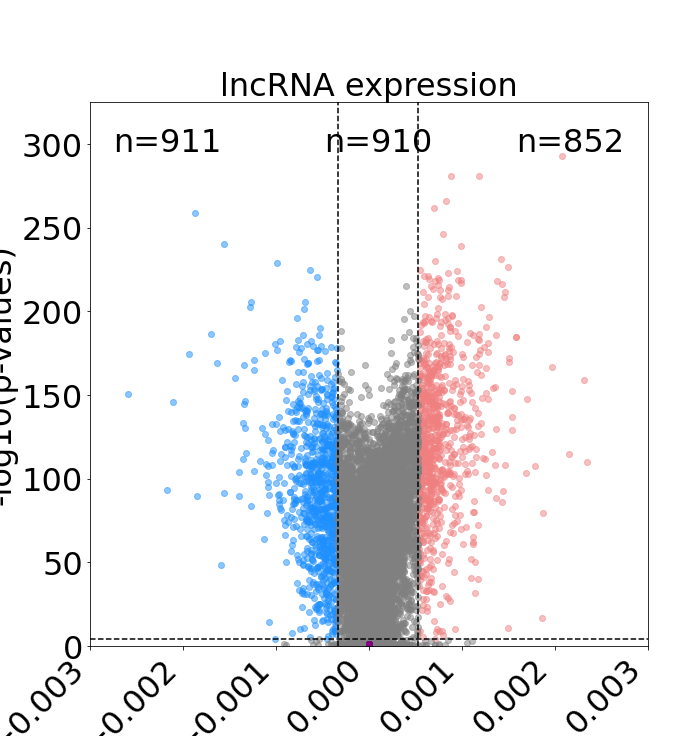

In [9]:
## make volcano plots using p-values associated with attribution values


pval_cutoff = 4

df_volcano_significant = attr_median[attr_median['pval'] > pval_cutoff]
df_volcano_pos = df_volcano_significant[df_volcano_significant['Median-Attributions'] > cutoff_pos]
df_volcano_neg = df_volcano_significant[df_volcano_significant['Median-Attributions'] < cutoff_neg]

df_volcano_nonsignificant = attr_median[~attr_median.index.isin(df_volcano_pos.index.tolist() + df_volcano_neg.index.tolist())]


## export genes with significant high positive or negative attribution values for GO and other downstream analyses
genes_high_pos = df_volcano_pos.index
genes_high_neg = df_volcano_neg.index


## first method of making neutral set by selecting similar number of neutral genes as the size of the positively or negatively highPos gene population at the center of the distribution
num_neutral = max([len(genes_high_pos), len(genes_high_neg)]) ## number of features included in neutral set is equal to set that has most features between high-negative and high-positive
attr_median_neutral = attr_median[attr_median['pval'] < 1.3]
neutral_position = int(len(attr_median_neutral)/2)
genes_neutral = attr_median_neutral.index.values[(neutral_position - int(num_neutral/2)):(neutral_position + int(num_neutral/2))]
df_volcano_neutral = attr_median[attr_median.index.isin(genes_neutral)]


## flip order of high negative attribution genes
genes_high_neg = genes_high_neg[::-1]


fig,ax = plt.subplots(figsize=(10,10))

font_size=32

plt.title('lncRNA expression', fontsize=font_size)
plt.plot(df_volcano_pos['Median-Attributions'], df_volcano_pos['pval'], 'o',
            color='lightcoral', alpha=0.5, rasterized=True)
plt.plot(df_volcano_neg['Median-Attributions'], df_volcano_neg['pval'], 'o',
         color='dodgerblue', alpha=0.5, rasterized=True)
plt.plot(df_volcano_nonsignificant['Median-Attributions'], df_volcano_nonsignificant['pval'], 'o',
         color='grey', alpha=0.5, rasterized=True)
plt.plot(df_volcano_neutral['Median-Attributions'], df_volcano_neutral['pval'], 'o',
         color='purple', alpha=0.5, rasterized=True)

plt.text(-0.00275, 310, 'n=' + str(len(genes_high_neg)), ha='left', va='top', fontsize=font_size)
plt.text(0.00275, 310, 'n=' + str(len(genes_high_pos)), ha='right', va='top', fontsize=font_size)
plt.text((cutoff_pos + cutoff_neg)/2, 310, 'n=' + str(len(genes_neutral)), ha='center', va='top', fontsize=font_size)

plt.axvline(cutoff_pos, linestyle='--', color='black')
plt.axvline(cutoff_neg, linestyle='--', color='black')
plt.axhline(4, linestyle='--', color='black')

plt.xticks(fontsize=font_size, rotation=45, ha='right', va='top')
plt.yticks(fontsize=font_size)

plt.xlabel('Attribution values', fontsize=font_size)
plt.ylabel('-log10(p-values)', fontsize=font_size)

plt.xlim(-0.003, 0.003)
plt.ylim(0, 325)

plt.savefig('../figures/volcano_attribution_lncRNA_median.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()


top genes is the number of top genes per tissue to plot


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


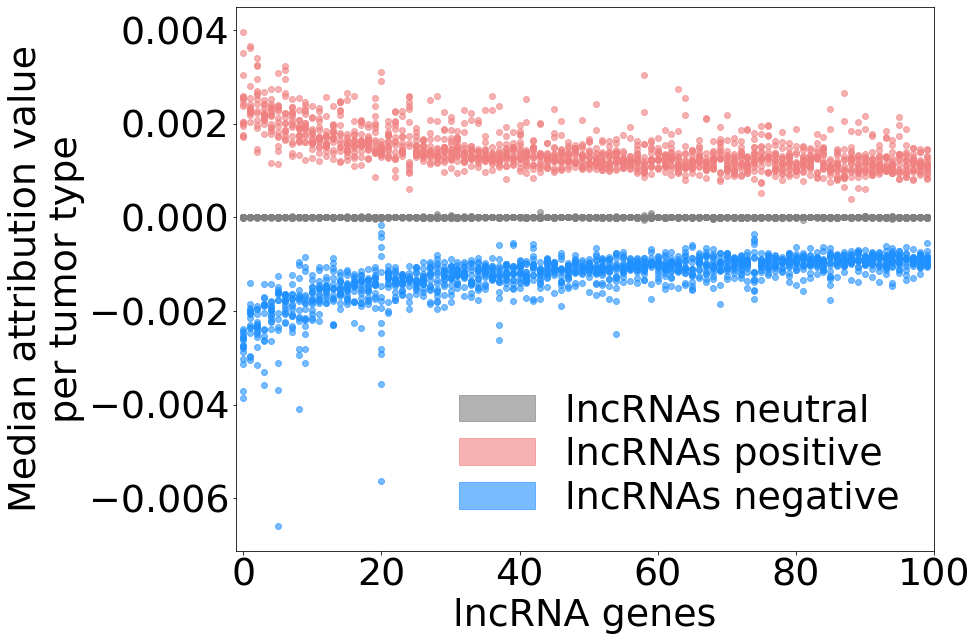

In [8]:
## Plot how attribution values of a set of genes look across cancer types

def plot_top_genes_perTissue(gene_list, groups, dct_tumor, df_pc, title, colors, save_as):
    print ('top genes is the number of top genes per tissue to plot')
    
    tumors = [x for x in set(dct_tumor.values()) if x not in ['stomach_cancer_tumor', 'ovarian_cancer_tumor']] ## remove stomach and ovarian cancer because we have low numbers
    
    
    tumor_samples = [x for x in df_pc.index if dct_tumor[x] in tumors]
    
    
    df = df_pc[df_pc.index.isin(tumor_samples)]
    
    
    fig,ax = plt.subplots(figsize=(12.5,10))
    
    
    font_size = 38
    
    starting_x = 0
    
    
    for ii,genes in enumerate(gene_list):
        
        genes = [gene for gene in genes if gene in df.columns]
        
        df_tpm = df[genes]
        
        for tumor_type in tumors:
            samples = [x for x in tumor_samples if dct_tumor[x] == tumor_type]
            median = df_tpm[df_tpm.index.isin(samples)].median(axis=0)
            df_tpm.loc['median_'+tumor_type] = median
            
        df_tpm = df_tpm[df_tpm.index.str.contains('median')]
        
        for iii,gene in enumerate(genes):
            x = [iii for x in range(len(df_tpm))]
            y = df_tpm[gene].tolist()
            
            plt.plot(x, y, 'o', color = colors[ii], alpha=0.6, rasterized=True)
        
        starting_x += len(genes)
        
    plt.ylabel('Median attribution value\nper tumor type', fontsize=font_size)
    plt.xlabel('lncRNA genes', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.xlim(-1, 100)
    
    ## manual legend
    patches = []
    for ii,group in enumerate(groups):
        patch = mpatches.Patch(color=colors[ii], label=group, alpha=0.6)
        patches.append(patch)
        
    plt.legend(handles=patches, frameon=False, fontsize=font_size, labelspacing = 0.2)
    
    plt.savefig(save_as + '.pdf', dpi=600, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    
num_genes = 100

genes_highPos = pd.read_csv(highPos_file,
                            header=None)[0].tolist()
genes_highPos = genes_highPos[:num_genes]


genes_highNeg = pd.read_csv(highNeg_file,
                            header=None)[0].tolist()    
genes_highNeg = genes_highNeg[:num_genes]


genes_neutral = pd.read_csv(neutral_file,
                            header=None)[0].tolist()
genes_neutral = genes_neutral[int(len(genes_neutral)/2)-int(num_genes/2): int(len(genes_neutral)/2)-int(num_genes/2)+num_genes]


title = 'Top ' + str(num_genes*2) + ' lncRNAs'
groups = ['lncRNAs neutral', 'lncRNAs positive', 'lncRNAs negative']
colors = ['grey', 'lightcoral', 'dodgerblue']
save_as = '../figures/attribution_lncRNA_median_tumors'

plot_top_genes_perTissue([genes_neutral, genes_highPos, genes_highNeg], groups, dct_tumor,
                         df_pc, title, colors, save_as)





## assessing conservation

In [9]:
## computing convervation scores

def assess_conservation(conservation_file, dct_enstToensg):
    
    df_conservation = pd.read_csv(conservation_file, sep='\t', comment='#', index_col=0)
    
    genes = set(df_conservation['query acc'].tolist())

    dct_conservation = {}
    for ii,gene in enumerate(genes):
        ## subset dataframe to one gene
        df_tmp = df_conservation[df_conservation['query acc'] == gene]
        ## remove human taxid because normalized score (see 4 lines below) will always be 1.847
        df_tmp = df_tmp[df_tmp['subject tax id'] != 9606]
        ## order dataframe by descending bit score values
        df_tmp = df_tmp.sort_values(by='bit score', axis=0, ascending=False)
        ## select match with greatest bit score for each taxid
        df_tmp.index = df_tmp['subject tax id']
        df_tmp = df_tmp[~df_tmp.index.duplicated(keep='first')]
        ## add normalized score corresponding to bit score normalized by query length
        df_tmp['normalized score'] = df_tmp['bit score'] / df_tmp['query length']

        normalized_score = np.sum(df_tmp['normalized score'])
        try:
            dct_conservation[df_tmp.iloc[0]['query acc']] = normalized_score
        except IndexError:
            ## this exception catches genes with no match in species other than Homo sapiens and assigns a score of 0
            dct_conservation[gene] = 0
            
    return dct_conservation


with open(dctEnstEnsg_file, 'rb') as f:
    dct_enstToensg = pickle.load(f)

## highPos lncRNAs
dct_conservation_highPos = assess_conservation(conservationPos_file, dct_enstToensg)

## highPos lncRNAs
dct_conservation_highNeg = assess_conservation(conservationNeg_file, dct_enstToensg)

## highPos lncRNAs
dct_conservation_neutral = assess_conservation(conservationNeutral_file, dct_enstToensg)
        
    
print ('ready to plot conservation scores')

ready to plot conservation scores


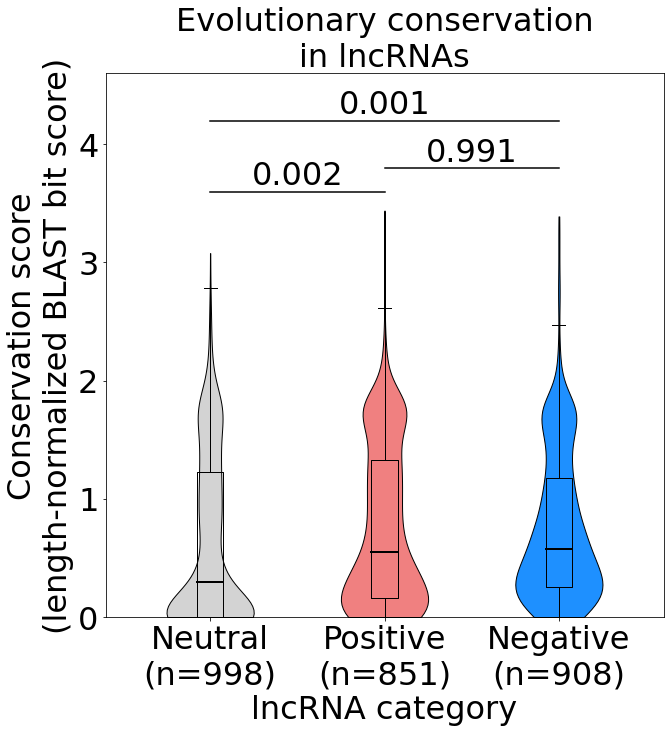

In [10]:
## plot conservation scores


dcts = [dct_conservation_neutral, dct_conservation_highPos, dct_conservation_highNeg]

fig,ax = plt.subplots(figsize=(10,10))

font_size = 32

plt.title('Evolutionary conservation\nin lncRNAs', fontsize=font_size)

tstat_neutralhighPos, pval_neutralhighPos = stats.ttest_ind([x for x in dct_conservation_neutral.values()],
                                                              [x for x in dct_conservation_highPos.values()])

tstat_neutralhighNeg, pval_neutralhighNeg = stats.ttest_ind([x for x in dct_conservation_neutral.values()],
                                                              [x for x in dct_conservation_highNeg.values()])

tstat_highPoshighNeg, pval_highPoshighNeg = stats.ttest_ind([x for x in dct_conservation_highPos.values()],
                                                              [x for x in dct_conservation_highNeg.values()])


groups = ['Neutral\n(n=' + str(len(dct_conservation_neutral)) + ')',
          'Positive\n(n=' + str(len(dct_conservation_highPos)) + ')',
          'Negative\n(n=' + str(len(dct_conservation_highNeg)) + ')']


for ii,group in enumerate(groups):
    
    y = dcts[ii].values()
    x = np.random.normal(ii, 0.15, size=len(y))
#     plt.scatter(x, y, color = ['grey', 'lightcoral', 'dodgerblue'][ii], alpha = 0.5)
    
    y_noOutliers = [x for x in y if x < 3.5] ## manually remove outliers to remove super long tail on violinplot
    
    vp = plt.violinplot(
            y_noOutliers, positions = [ii],
        showmeans=False, showmedians=False,
            showextrema=False)

    for pc in vp['bodies']:
        pc.set_facecolor(['lightgrey', 'lightcoral', 'dodgerblue'][ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    box1 = plt.boxplot(y, positions = [ii], showfliers=False)
    plt.setp(box1['medians'], color='black', linewidth=2)
#     plt.text(ii, 0, 'n=' + str(len(y)), fontsize = font_size/1.5, ha='center', va='bottom')
    
    
plt.plot([0,1], [3.6, 3.6], color='black')
plt.plot([1,2], [3.8, 3.8], color='black')
plt.plot([0,2], [4.2, 4.2], color='black')

write_pval(pval_neutralhighPos, 0.5, 3.6, 0.001)
write_pval(pval_highPoshighNeg, 1.5, 3.8, 0.001)
write_pval(pval_neutralhighNeg, 1, 4.2, 0.001)

plt.xticks(range(len(groups)), groups, fontsize=font_size)
plt.xlabel('lncRNA category', fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('Conservation score\n(length-normalized BLAST bit score)', fontsize=font_size)
plt.xlim(-0.6, 2.6)
plt.ylim(0,4.6)

plt.savefig('../figures/conservation_score_lncRNA.pdf',
            dpi=600, bbox_inches='tight')
plt.show()
plt.close()

## assessing pyknon density

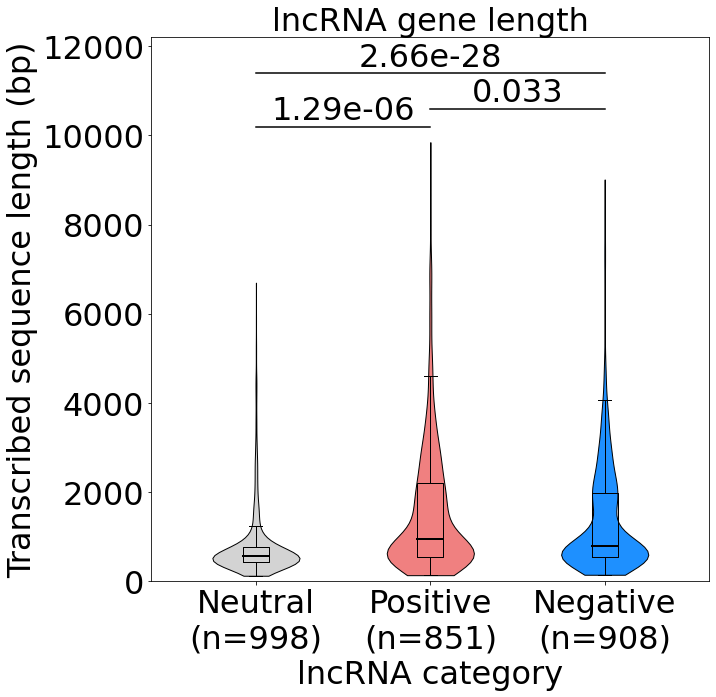

median pyknon density in neutral: 2.413334167879239
median pyknon density in negative: 16.982292184438098
ratio: 7.036858969001212


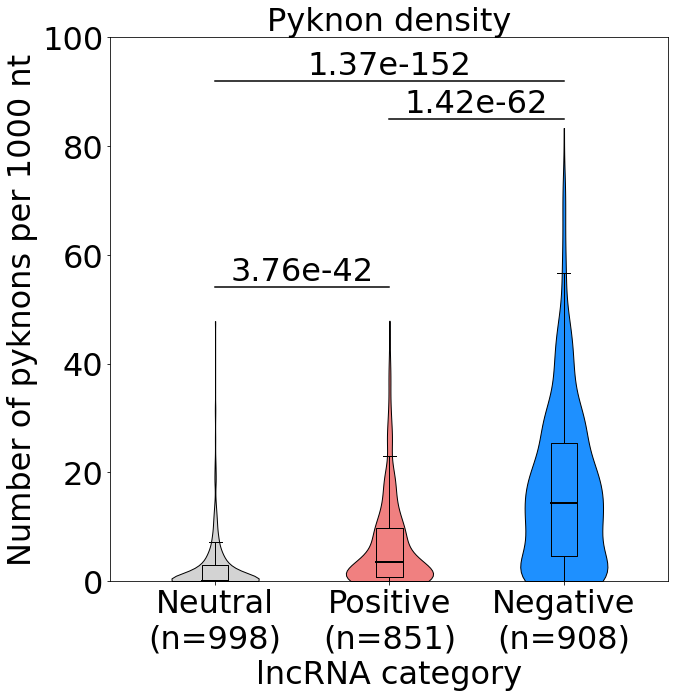

In [11]:
## plot number of pyknons per gene (normalized to gene length)


with open(pyknonPos_file, 'rb') as dct_pyknon_highPos:
    dct_pyknon_highPos = pickle.load(dct_pyknon_highPos)
with open(pyknonNeg_file, 'rb') as dct_pyknon_highNeg:
    dct_pyknon_highNeg = pickle.load(dct_pyknon_highNeg)
with open(pyknonNeutral_file, 'rb') as dct_pyknon_neutral:
    dct_pyknon_neutral = pickle.load(dct_pyknon_neutral)
    
        

## normalization of number of pyknons by gene length
## also make dictionaries containing gene lengths

dct_length_highPos = {}
for ii, seq_record in enumerate(SeqIO.parse(highPos_fasta, 'fasta')):
        
    gene_id = seq_record.id.strip().split('|')[-3]
    
    dct_pyknon_highPos[gene_id] = len(dct_pyknon_highPos[gene_id])/len(seq_record.seq) * 1000
    dct_length_highPos[gene_id] = len(seq_record.seq)
    
    
dct_length_highNeg = {}
for ii, seq_record in enumerate(SeqIO.parse(highNeg_fasta, 'fasta')):
        
    gene_id = seq_record.id.strip().split('|')[-3]
    
    dct_pyknon_highNeg[gene_id] = len(dct_pyknon_highNeg[gene_id])/len(seq_record.seq) * 1000
    dct_length_highNeg[gene_id] = len(seq_record.seq)
    
    
dct_length_neutral = {}
for ii, seq_record in enumerate(SeqIO.parse(neutral_fasta, 'fasta')):
        
    gene_id = seq_record.id.strip().split('|')[-3]
    
    dct_pyknon_neutral[gene_id] = len(dct_pyknon_neutral[gene_id])/len(seq_record.seq) * 1000
    dct_length_neutral[gene_id] = len(seq_record.seq)
    
    
dcts_lengths = [dct_length_neutral, dct_length_highPos, dct_length_highNeg]
dcts_pyknons = [dct_pyknon_neutral, dct_pyknon_highPos, dct_pyknon_highNeg]


groups = ['Neutral\n(n=' + str(len(dct_length_neutral)) + ')',
          'Positive\n(n=' + str(len(dct_length_highPos)) + ')',
          'Negative\n(n=' + str(len(dct_length_highNeg)) + ')']

## plot lncRNA gene lengths
fig,ax = plt.subplots(figsize=(10,10))

font_size = 32

plt.title('lncRNA gene length', fontsize = font_size)

tstat_neutralhighPos, pval_neutralhighPos = stats.ttest_ind([dct_length_neutral[x] for x in dct_length_neutral],
                                                              [dct_length_highPos[x] for x in dct_length_highPos])

tstat_neutralhighNeg, pval_neutralhighNeg = stats.ttest_ind([dct_length_neutral[x] for x in dct_length_neutral],
                                                              [dct_length_highNeg[x] for x in dct_length_highNeg])

tstat_highPoshighNeg, pval_highPoshighNeg = stats.ttest_ind([dct_length_highPos[x] for x in dct_length_highPos],
                                                              [dct_length_highNeg[x] for x in dct_length_highNeg])


for ii,group in enumerate(groups):
    
    y = [dcts_lengths[ii][x] for x in dcts_lengths[ii]]
    x = np.random.normal(ii, 0.15, size=len(y))
#     plt.scatter(x, y, color = ['grey', 'lightcoral', 'dodgerblue'][ii], alpha = 0.5)
    
    y_noOutliers = [x for x in y if x < 10000] ## manually remove outliers to remove super long tail on violinplot
    
    vp = plt.violinplot(
            y_noOutliers, positions = [ii],
        showmeans=False, showmedians=False,
            showextrema=False)

    for pc in vp['bodies']:
        pc.set_facecolor(['lightgrey', 'lightcoral', 'dodgerblue'][ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    box1 = plt.boxplot(y, positions = [ii], showfliers=False)
    plt.setp(box1['medians'], color='black', linewidth=2)
#     plt.text(ii, 0, 'n=' + str(len(y)), fontsize = font_size/1.5, ha='center', va='bottom')
    
    
plt.plot([0,1], [10200, 10200], color='black')
plt.plot([1,2], [10600, 10600], color='black')
plt.plot([0,2], [11400, 11400], color='black')

write_pval(pval_neutralhighPos, 0.5, 10200, 0.001)
write_pval(pval_highPoshighNeg, 1.5, 10600, 0.001)
write_pval(pval_neutralhighNeg, 1, 11400, 0.001)

plt.xticks(range(len(groups)), groups, fontsize=font_size)
plt.xlabel('lncRNA category', fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('Transcribed sequence length (bp)', fontsize=font_size)
plt.xlim(-0.6, 2.6)
plt.ylim(0, 12200)

plt.savefig('../figures/transcriptLength_lncRNA.pdf',
            dpi=600, bbox_inches='tight')
plt.show()
plt.close()



## plot pyknon density
fig,ax = plt.subplots(figsize=(10,10))

font_size = 32

plt.title('Pyknon density', fontsize=font_size)

tstat_neutralhighPos, pval_neutralhighPos = stats.ttest_ind([dct_pyknon_neutral[x] for x in dct_pyknon_neutral],
                                                              [dct_pyknon_highPos[x] for x in dct_pyknon_highPos])

tstat_neutralhighNeg, pval_neutralhighNeg = stats.ttest_ind([dct_pyknon_neutral[x] for x in dct_pyknon_neutral],
                                                              [dct_pyknon_highNeg[x] for x in dct_pyknon_highNeg])

tstat_highPoshighNeg, pval_highPoshighNeg = stats.ttest_ind([dct_pyknon_highPos[x] for x in dct_pyknon_highPos],
                                                              [dct_pyknon_highNeg[x] for x in dct_pyknon_highNeg])

print ('median pyknon density in neutral:', np.mean([dct_pyknon_neutral[x] for x in dct_pyknon_neutral]))
print ('median pyknon density in negative:', np.mean([dct_pyknon_highNeg[x] for x in dct_pyknon_highNeg]))
print ('ratio:', np.mean([dct_pyknon_highNeg[x] for x in dct_pyknon_highNeg])/np.mean([dct_pyknon_neutral[x] for x in dct_pyknon_neutral]))


for ii,group in enumerate(groups):
    
    y = [dcts_pyknons[ii][x] for x in dcts_pyknons[ii]]
    x = np.random.normal(ii, 0.15, size=len(y))
#     plt.scatter(x, y, color = ['grey', 'lightcoral', 'dodgerblue'][ii], alpha = 0.5)
    
    y_noOutliers = [x for x in y if x < 90] ## manually remove outliers to remove super long tail on violinplot
    
    vp = plt.violinplot(
            y_noOutliers, positions = [ii],
        showmeans=False, showmedians=False,
            showextrema=False)

    for pc in vp['bodies']:
        pc.set_facecolor(['lightgrey', 'lightcoral', 'dodgerblue'][ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    box1 = plt.boxplot(y, positions = [ii], showfliers=False)
    plt.setp(box1['medians'], color='black', linewidth=2)
#     plt.text(ii, 0, 'n=' + str(len(y)), fontsize = font_size/1.5, ha='center', va='bottom')
    
    
plt.plot([0,1], [54, 54], color='black')
plt.plot([1,2], [85, 85], color='black')
plt.plot([0,2], [92, 92], color='black')


write_pval(pval_neutralhighPos, 0.5, 54, 0.001)
write_pval(pval_highPoshighNeg, 1.5, 85, 0.001)
write_pval(pval_neutralhighNeg, 1, 92, 0.001)
    
plt.xticks(range(len(groups)), groups, fontsize=font_size)
plt.xlabel('lncRNA category', fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('Number of pyknons per 1000 nt', fontsize=font_size)
plt.xlim(-0.6, 2.6)
plt.ylim(0, 100)

plt.savefig('../figures/lncRNA_pyknons.pdf',
            dpi=600, bbox_inches='tight')
plt.show()
plt.close()
